Imports Libraries



In [ ]:
!pip install stable_baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 9.9 MB/s 
     |████████████████████████████████| 1.5 MB 50.3 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=9e349dd8ce0582405593e1a6e989df7bc02aa3e86f65912beeb244b4264af939
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
# Gym stuff
import gym
from gym import spaces
from gym.utils import seeding
#import gym_anytrading
#from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import DQN
#from stable_baselines3 import ACER
#from stable_baselines3 import MlpPolicy, CnnPolicy, LnMlpPolicy

from stable_baselines3.dqn.policies import MlpPolicy, CnnPolicy

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from enum import Enum
import statistics


Creates trading environment

In [ ]:


class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(Enum):
    Short = 0
    Long = 1
    Hold = 2

    def opposite(self):
        if self == Positions.Hold:
           return Positions.Hold
        elif self == Positions.Long: 
          return Positions.Short 
        else:
          return Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 100.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or 
            (action == Actions.Sell.value and self._position == Positions.Long) or 
            (action == Actions.Hold.value and self._position == Positions.Hold)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError




class BinaryEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left'):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size)

        self.trade_fee = 0.0003  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0  # pip

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Short:
                  step_reward += 1
            elif self._position == Positions.Long:
                  step_reward += 1


        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

Imports Data Frame

In [ ]:
with open("/content/drive/MyDrive/Other Projects/BTCUSD_1day.pickle", \
          "rb") as f:
      df \
      = pickle.load(f)

df

,Symbol,Open,High,Low,Close,Volume,sma40,OBV
Date,,,,,,,,
2015-10-08,BTCUSD,242.50,245.00,242.50,243.95,18.80,0.00000,0.00
2015-10-09,BTCUSD,243.95,249.97,243.60,245.39,30.99,0.00000,30.99
2015-10-10,BTCUSD,245.39,246.30,244.60,246.30,12.17,0.00000,43.16
2015-10-11,BTCUSD,246.30,249.50,246.30,249.50,12.22,0.00000,55.38
2015-10-12,BTCUSD,249.50,249.50,247.60,247.60,38.28,0.00000,17.10
...,...,...,...,...,...,...,...,...
2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,7009.73250,402187.43
2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,6969.53125,399854.09
2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,6936.14925,402337.69


In [ ]:

lower_limit = 50
upper_limit = 1800

env_random = BinaryEnv(df=df, frame_bound=(lower_limit,upper_limit), window_size=5)


info {'total_reward': 533.0, 'total_profit': 46.837521525203364, 'position': 1}
info {'total_reward': 492.0, 'total_profit': 48.47915774436826, 'position': 0}
info {'total_reward': 532.0, 'total_profit': 16.652754585070923, 'position': 0}
info {'total_reward': 517.0, 'total_profit': 45.61732521661341, 'position': 1}
info {'total_reward': 530.0, 'total_profit': 28.623726558789322, 'position': 0}
info {'total_reward': 534.0, 'total_profit': 20.518906924311306, 'position': 0}
info {'total_reward': 518.0, 'total_profit': 58.000115428412464, 'position': 0}
info {'total_reward': 509.0, 'total_profit': 9.323327355134738, 'position': 1}
info {'total_reward': 547.0, 'total_profit': 40.19374654436231, 'position': 1}
info {'total_reward': 540.0, 'total_profit': 59.17295968726763, 'position': 0}
info {'total_reward': 514.0, 'total_profit': 37.538857351021534, 'position': 0}
info {'total_reward': 559.0, 'total_profit': 9.895546210546195, 'position': 1}
info {'total_reward': 512.0, 'total_profit': 1

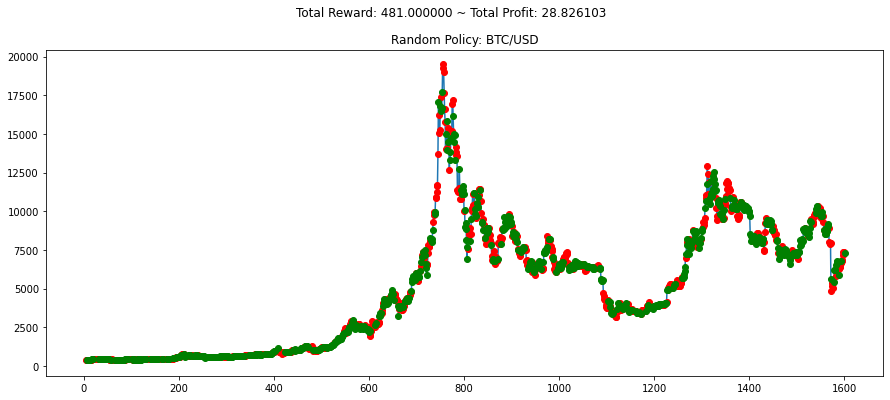

In [ ]:
state = env_random.reset()
while True: 
    action = env_random.action_space.sample()
    n_state, reward, done, info = env_random.step(action)
    if done: 
        print("info", info)
        break


avg_reward = []

'''
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
'''

for x in range(100):
  state = env_random.reset()
  while True: 
    action = env_random.action_space.sample()
    n_state, reward, done, info = env_random.step(action)
    if done: 
        print("info", info)
        break
  avg_reward.append(info['total_reward'])

print("Average reward: ",(statistics.mean(avg_reward)/(upper_limit - lower_limit)))






plt.figure(figsize=(15,6))
plt.cla()
env_random.render_all()
plt.title("Random Policy: BTC/USD")
plt.show()

2.1.4. Create Custom Environments

In [ ]:
#from gym_anytrading.envs import StocksEnv

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 
                                     'Volume',
                                     'sma7',
                                     'sma40',
                                     'sma99',
                                     'bb_bbm',
                                     'bb_bbh',
                                     'bb_bbl',
                                     'psar',
                                     'MACD',
                                     'RSI',
                                     'OBV'
                                     ]].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
class MyCustomEnv(BinaryEnv):
    _process_data = add_signals
    


Reload the model

In [ ]:
#env2 = MyCustomEnv(df=df, window_size=5, frame_bound=(18000,39000))

model = DQN.load('/content/drive/MyDrive/Other Projects/EA_Robot_day_v6.0', env=env)


FileNotFoundError: ignored

#3. Build Environment and Train

In [ ]:
#Original Environment
#env_maker = lambda: gym.make('forex-v0', df=df, frame_bound=(5,100), window_size=5)

#Custom Environment
env_maker = lambda: MyCustomEnv(df=df, window_size=50, frame_bound=(900,1000))
#env_maker = lambda: MyCustomEnv(df=df, window_size=5, frame_bound=(1000,1800))

env = DummyVecEnv([env_maker])

KeyError: ignored

In [ ]:
#model = A2C('MlpLstmPolicy', env, verbose=1) 
model = DQN(MlpPolicy, env, verbose=1)
#model = ACER(MlpPolicy, env, verbose=1)

model.learn(total_timesteps=10000)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9168     |
|    time_elapsed     | 0        |
|    total_timesteps  | 396      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.248    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8528     |
|    time_elapsed     | 0        |
|    total_timesteps  | 792      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 8639     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1188     |
----------------------------------
----------------------------------
| r

# Evaluation




In [ ]:
#env = gym.make('forex-v0', df=df, frame_bound=(5,100), window_size=1)
env = MyCustomEnv(df=df, window_size=50, frame_bound=(lower_limit,upper_limit))


avg_reward = []

'''
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
'''

for x in range(100):
  obs = env.reset()
  while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
  avg_reward.append(info['total_reward'])

print("Average reward: ",statistics.mean(avg_reward)/(upper_limit-lower_limit))

info {'total_reward': 81.0, 'total_profit': 64.64561294408145, 'position': 1}
info {'total_reward': 105.0, 'total_profit': 89.12063568403943, 'position': 1}
info {'total_reward': 95.0, 'total_profit': 71.4449310207515, 'position': 1}
info {'total_reward': 67.0, 'total_profit': 82.81987313830851, 'position': 1}
info {'total_reward': 85.0, 'total_profit': 85.86084116281522, 'position': 1}
info {'total_reward': 65.0, 'total_profit': 69.31439780201596, 'position': 1}
info {'total_reward': 67.0, 'total_profit': 81.51105914046892, 'position': 1}
info {'total_reward': 87.0, 'total_profit': 97.63704466572021, 'position': 1}
info {'total_reward': 83.0, 'total_profit': 145.31872668789816, 'position': 1}
info {'total_reward': 79.0, 'total_profit': 84.75145501297112, 'position': 1}
info {'total_reward': 79.0, 'total_profit': 112.35230076992418, 'position': 1}
info {'total_reward': 81.0, 'total_profit': 59.35820619309573, 'position': 1}
info {'total_reward': 99.0, 'total_profit': 60.162722619118746

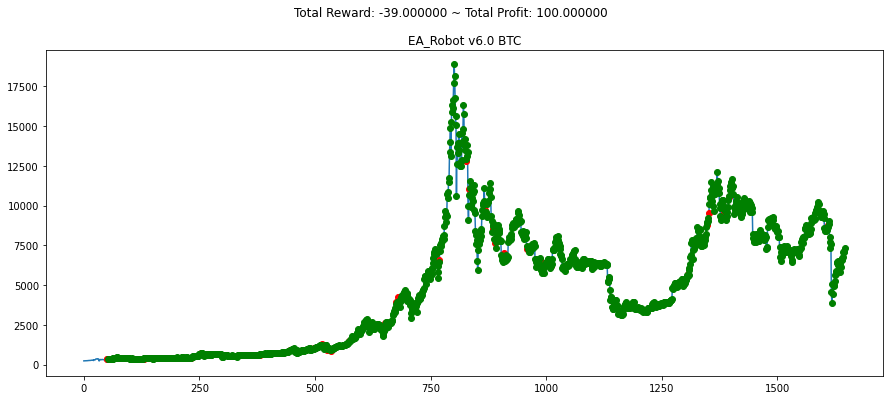

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.title("EA_Robot v6.0 BTC")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Other Projects/EA_Robot_day_v5.0')

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import os

In [ ]:
save_path = os.path.join('Training', 'Saved Models')
log_path = os.path.join('Training', 'Logs')

In [ ]:
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=1000, verbose=1)
eval_callback = EvalCallback(env, 
                             callback_on_new_best=stop_callback, 
                             eval_freq=100, 
                             best_model_save_path=save_path, 
                             verbose=1)

In [ ]:
model = DQN('MlpPolicy', env, verbose = 1, tensorboard_log=log_path)



In [ ]:
model.learn(total_timesteps=10000, callback=eval_callback)

